In [1]:
import math
import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.CIFAR10(
    root='cifar10',
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ]),
    download=False)

loader = data.DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
def to_image(tensor, lo=-1, hi=1.):
    if tensor.ndim == 4:
        tensor = tensor.squeeze(0)
    tensor = tensor.permute((1, 2, 0))
    array = tensor.detach().numpy()
    lo = lo or array.min()
    hi = hi or array.max()
    array = (array - lo) / (hi - lo)
    array = np.uint8(255 * array)
    return Image.fromarray(array)

In [4]:
encoder = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=2),
    nn.ReLU(),
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=1),
    nn.Tanh()
)

for image, label in loader:
    print(image.min())
    print(image.max())
    z = encoder(image)
    reconstructed = decoder(z)
    print(image.shape)
    print(z.shape)
    print(reconstructed.shape)
    break

tensor(-1.)
tensor(1.)
torch.Size([64, 3, 32, 32])
torch.Size([64, 16, 15, 15])
torch.Size([64, 3, 32, 32])


In [8]:
mse = nn.MSELoss()
optimizer = optim.SGD(
    params=[
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ],
    lr = 0.1,
    momentum = 0.9,
    weight_decay=0.01
)

encoder.train()
decoder.train()
for epoch in range(2):
    for i, (image, label) in enumerate(loader):
        z = encoder(image)
        reconstructed = decoder(z)
        loss = mse(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(loss.item())
        if loss.item() < 0.03:
            break

0.028789209201931953
0.026936570182442665


tensor(0.0240, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)


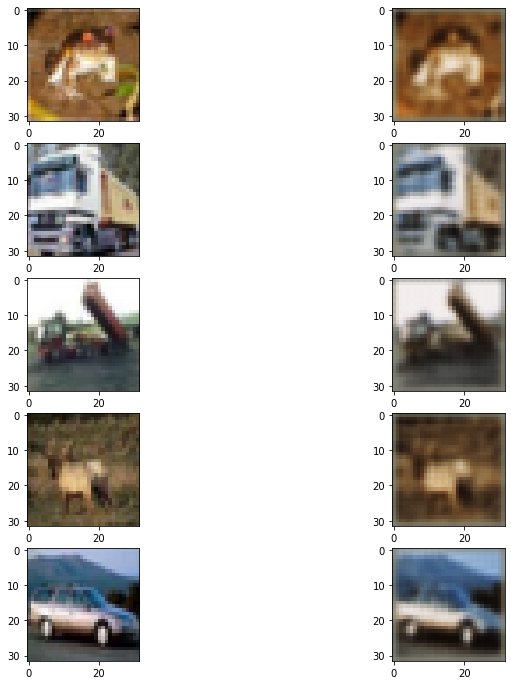

In [11]:
# this is critical, or the batch normalization will change
encoder.eval()
decoder.eval()

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
for i in range(5):
    image, label = dataset[i]
    reconstructed = decoder(encoder(image.unsqueeze(0)))
    ax[i, 0].imshow(to_image(image))
    ax[i, 1].imshow(to_image(reconstructed))
    print(mse(image.unsqueeze(0), reconstructed))

plt.show()